In [1]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns

LABELS = ['pocket','swing','texting','whatever'] 

### read raw data files and add label colomn by parsing the file name 

In [2]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    data['source']=file  
    for label in LABELS:
        if label.lower() in file.lower():  ## .startswith(label.lower()):
            # print 'add label : ', label
            data['label']=label
            data['devicemode'] =  LABELS.index(label)
            return data
    data['label']=LABELS[-1]
    return data

In [3]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [4]:
rdf = loadFiles(r'../raw-data/utf8')

loading files from :  ../raw-data/utf8
loading :  SwingRightPhoneDownScBody.csv
loading :  swingLeftHandPhoneDownScBody.csv
loading :  SwingRightPhoneDown.csv
loading :  TextingStatic2.csv
loading :  TextingPointingDorwatd.csv
loading :  LeftPocketStatic.csv
loading :  swing3.csv
loading :  Pocket2.csv
loading :  PocketLeftAidePhoneDownScBodyLoose.csv
loading :  TextingStatic.csv
loading :  TextingRight.csv
loading :  Texting2.csv
loading :  RightPocket.csv
loading :  SwingRight2.csv
loading :  swing4.csv
loading :  PocketLeftNormalWalking.csv
loading :  swing2.csv
loading :  SwingLeftNormal.csv
loading :  LeftPocketJeansNormalWalk.csv


In [5]:
rdf.describe()

,Bx,By,Bz,I,Unnamed: 11,Unnamed: 12,devicemode,gFy,gFz,gfx,p,time,wx,wy,wz
count,130802.000000,130802.000000,130802.000000,40012.000000,0.0,0.0,130802.000000,130802.000000,130802.000000,130802.000000,130802.000000,130802.000000,130802.000000,130802.000000,130802.000000
mean,1.185409,14.423237,-6.186041,47.273518,NaN,NaN,0.897089,-0.563056,0.210243,-0.119330,977.916116,102.684475,0.016922,0.018004,0.044150
std,24.671567,24.316490,21.570948,110.660849,NaN,NaN,0.706767,0.499671,0.475558,0.723627,2.700383,67.615823,0.900235,1.499751,1.310727
min,-50.332600,-44.139100,-43.936200,0.000000,NaN,NaN,0.000000,-3.513000,-2.649900,-2.321700,969.409300,0.005000,-6.055000,-12.893800,-9.260000
25%,-19.432100,-2.107200,-25.871300,0.000000,NaN,NaN,0.000000,-0.857100,-0.057500,-0.642200,978.328800,46.927000,-0.401600,-0.327500,-0.774400
50%,4.267900,22.793600,-11.953750,0.000000,NaN,NaN,1.000000,-0.628800,0.075200,-0.045200,978.525300,94.294500,0.000300,0.000200,0.000100
75%,23.768600,33.143600,11.514300,14.000000,NaN,NaN,1.000000,-0.229800,0.392000,0.272400,978.705900,148.888000,0.383500,0.443000,0.814000
max,288.967900,65.843200,42.114300,387.000000,NaN,NaN,2.000000,0.896700,1.761300,2.373100,980.680700,377.232000,6.345700,11.385500,5.048500


In [6]:
rdf.dropna(axis=1,inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130802 entries, 0 to 6572
Data columns (total 14 columns):
Bx            130802 non-null float64
By            130802 non-null float64
Bz            130802 non-null float64
devicemode    130802 non-null int64
gFy           130802 non-null float64
gFz           130802 non-null float64
gfx           130802 non-null float64
label         130802 non-null object
p             130802 non-null float64
source        130802 non-null object
time          130802 non-null float64
wx            130802 non-null float64
wy            130802 non-null float64
wz            130802 non-null float64
dtypes: float64(11), int64(1), object(2)
memory usage: 15.0+ MB


In [7]:
rdf.head()

,Bx,By,Bz,devicemode,gFy,gFz,gfx,label,p,source,time,wx,wy,wz
0,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.6127,SwingRightPhoneDownScBody.csv,0.006,0.2233,-0.4407,-0.4187
1,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.5864,SwingRightPhoneDownScBody.csv,0.011,0.2233,-0.4407,-0.4187
2,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.021,0.2233,-0.4407,-0.4187
3,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.045,-0.0982,0.4523,-0.0352
4,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.045,-0.0982,0.4523,-0.0352


### load validation 

In [8]:
rvl = loadFiles(r'../raw-data/validation/utf8')

loading files from :  ../raw-data/validation/utf8
loading :  back_pocket_walk2017-09-0315.59.02.csv
loading :  text_walk2017-09-0315.53.12.csv
loading :  swing_walk2017-09-0316.04.51.csv


In [9]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

,Bx,By,Bz,I,Latitude,Longitude,Speed (m/s),ax,ay,az,gFy,gFz,gfx,label,time,wx,wy,wz
0,-4.56,-47.82,-21.60,10240.0,0.0,0.0,0.0,0.0341,0.0945,-0.0334,0.43,0.8873,-0.043,pocket,0.024,-0.1136,0.0586,0.0391
1,-4.50,-47.94,-21.24,10240.0,0.0,0.0,0.0,0.0341,0.0945,-0.0334,0.43,0.8873,-0.043,pocket,0.079,-0.1136,0.0586,0.0391
2,-4.50,-47.94,-21.24,10240.0,0.0,0.0,0.0,0.0341,0.0945,-0.0334,0.43,0.8873,-0.043,pocket,0.153,-0.1173,0.0147,-0.0342
3,-4.50,-47.94,-21.24,10240.0,0.0,0.0,0.0,0.0341,0.2200,-0.0944,0.43,0.8873,-0.043,pocket,0.156,-0.1173,0.0147,-0.0342
4,-4.20,-47.94,-21.00,10240.0,0.0,0.0,0.0,0.0341,0.2200,-0.0944,0.43,0.8873,-0.043,pocket,0.156,-0.1173,0.0147,-0.0342


## preprocessing 
#### todos :lowpass filter , remove dc & normlaize 


## generate features 
#### todos : calculate norm feature for g-force , gyro 
####  avarage norm on sliding window 

In [10]:
rdf['gforce'] = np.sqrt(rdf['gfx']**2 + rdf['gFy']**2 + rdf['gFz']**2) 
rdf['gyro'] = np.sqrt(rdf['wx']**2 + rdf['wy']**2 + rdf['wz']**2) 

In [11]:
rdf.head()

,Bx,By,Bz,devicemode,gFy,gFz,gfx,label,p,source,time,wx,wy,wz,gforce,gyro
0,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.6127,SwingRightPhoneDownScBody.csv,0.006,0.2233,-0.4407,-0.4187,0.689125,0.647603
1,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.5864,SwingRightPhoneDownScBody.csv,0.011,0.2233,-0.4407,-0.4187,0.689125,0.647603
2,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.021,0.2233,-0.4407,-0.4187,0.983347,0.647603
3,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.045,-0.0982,0.4523,-0.0352,0.983347,0.464174
4,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,SwingRightPhoneDownScBody.csv,0.045,-0.0982,0.4523,-0.0352,0.983347,0.464174


In [12]:
rdf['mgforce'] = rdf['gforce'].rolling(window=128,center=False).mean()
rdf['mgforce'].fillna(value=rdf['mgforce'].mean(),inplace=True)

rdf['mgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['mgyro'].fillna(value=rdf['mgyro'].mean(),inplace=True)


In [13]:
rdf['vgforce'] = rdf['gforce'].rolling(window=128,center=False).var()
rdf['vgforce'].fillna(value=rdf['vgforce'].mean(),inplace=True)
rdf['vgyro'] = rdf['gyro'].rolling(window=128,center=False).mean()
rdf['vgyro'].fillna(value=rdf['vgyro'].mean(),inplace=True)

In [14]:
#rdf.dropna(inplace=True)
rdf.drop('source',axis=1).head(10)

,Bx,By,Bz,devicemode,gFy,gFz,gfx,label,p,time,wx,wy,wz,gforce,gyro,mgforce,mgyro,vgforce,vgyro
0,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.6127,0.006,0.2233,-0.4407,-0.4187,0.689125,0.647603,1.115267,1.656783,0.120552,1.656783
1,-28.4439,-5.0415,-30.7419,1,0.4008,0.5604,0.0143,swing,978.5864,0.011,0.2233,-0.4407,-0.4187,0.689125,0.647603,1.115267,1.656783,0.120552,1.656783
2,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,0.021,0.2233,-0.4407,-0.4187,0.983347,0.647603,1.115267,1.656783,0.120552,1.656783
3,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,0.045,-0.0982,0.4523,-0.0352,0.983347,0.464174,1.115267,1.656783,0.120552,1.656783
4,-28.4439,-5.0415,-30.7419,1,0.4479,0.8753,0.0144,swing,978.5864,0.045,-0.0982,0.4523,-0.0352,0.983347,0.464174,1.115267,1.656783,0.120552,1.656783
5,-27.9343,-4.7241,-34.0576,1,0.4479,0.8753,0.0144,swing,978.5864,0.046,-0.0982,0.4523,-0.0352,0.983347,0.464174,1.115267,1.656783,0.120552,1.656783
6,-27.9343,-4.7241,-34.0576,1,0.4727,1.0072,-0.1047,swing,978.5864,0.107,-0.0982,0.4523,-0.0352,1.117524,0.464174,1.115267,1.656783,0.120552,1.656783
7,-26.9562,-4.6585,-35.2692,1,0.4727,1.0072,-0.1047,swing,978.5864,0.108,-0.0982,0.4523,-0.0352,1.117524,0.464174,1.115267,1.656783,0.120552,1.656783
8,-26.9562,-4.6585,-35.2692,1,0.4406,1.1935,-0.1260,swing,978.5864,0.160,-0.0982,0.4523,-0.0352,1.278455,0.464174,1.115267,1.656783,0.120552,1.656783
9,-27.8183,6.9717,-29.2908,1,0.4406,1.1935,-0.1260,swing,978.5864,0.183,-0.0982,0.4523,-0.0352,1.278455,0.464174,1.115267,1.656783,0.120552,1.656783


### visualize

In [17]:
cor_mat = rdf.iloc[:,13:].corr()
cor_mat

,wz,gforce,gyro,mgforce,mgyro,vgforce,vgyro
wz,1.000000,0.020693,0.090083,0.068074,0.065809,0.089839,0.065809
gforce,0.020693,1.000000,0.223875,0.262679,0.223749,0.212932,0.223749
gyro,0.090083,0.223875,1.000000,0.534594,0.696733,0.512794,0.696733
mgforce,0.068074,0.262679,0.534594,1.000000,0.761181,0.709021,0.761181
mgyro,0.065809,0.223749,0.696733,0.761181,1.000000,0.705773,1.000000
vgforce,0.089839,0.212932,0.512794,0.709021,0.705773,1.000000,0.705773
vgyro,0.065809,0.223749,0.696733,0.761181,1.000000,0.705773,1.000000


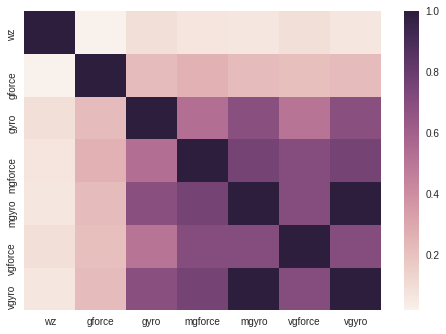

In [18]:
sns.heatmap(cor_mat)

Axes(0.125,0.125;0.775x0.755)


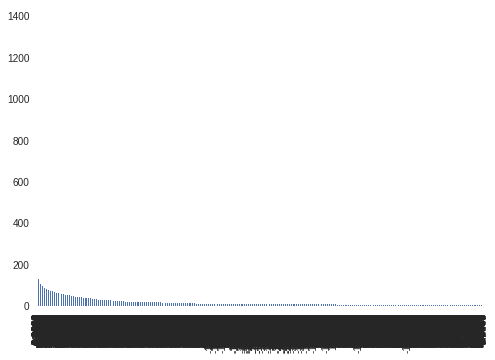

In [22]:
print(rdf.iloc[:,12].value_counts().plot(kind = 'bar'))

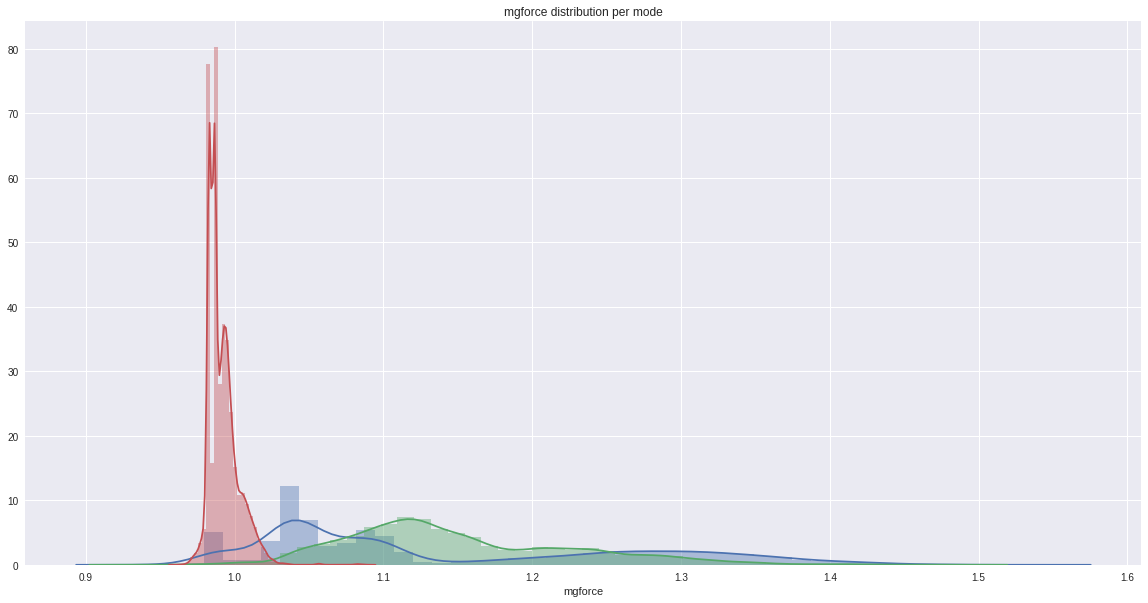

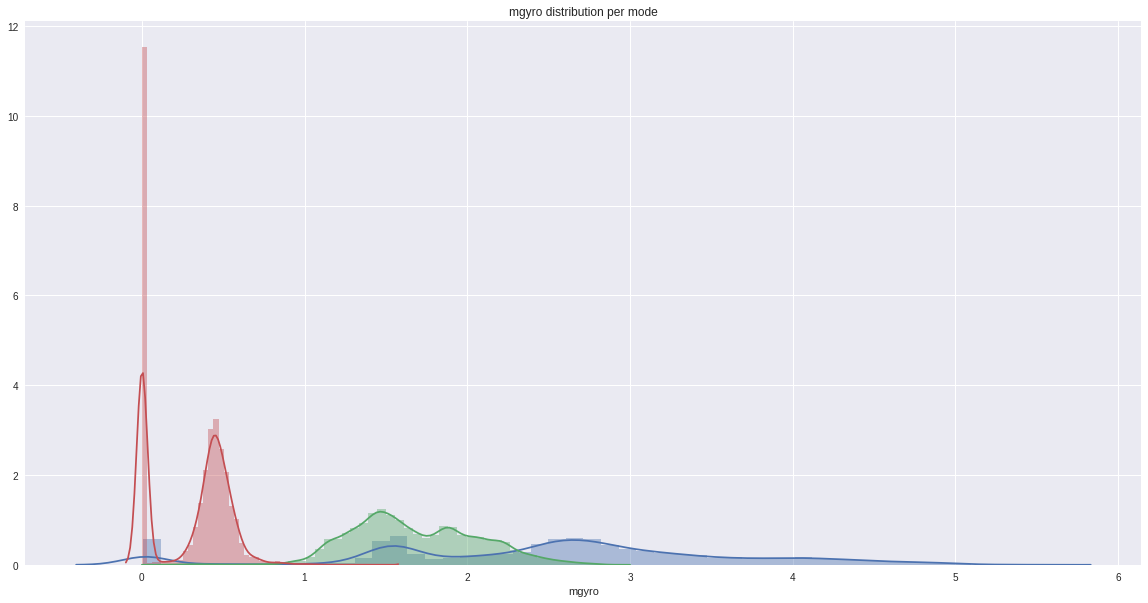

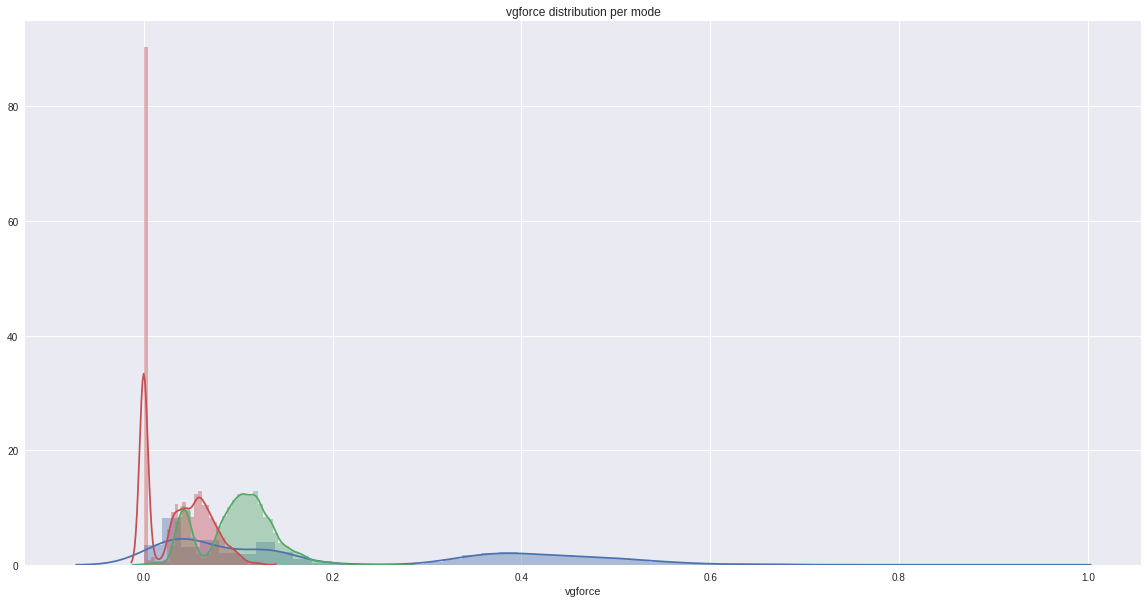

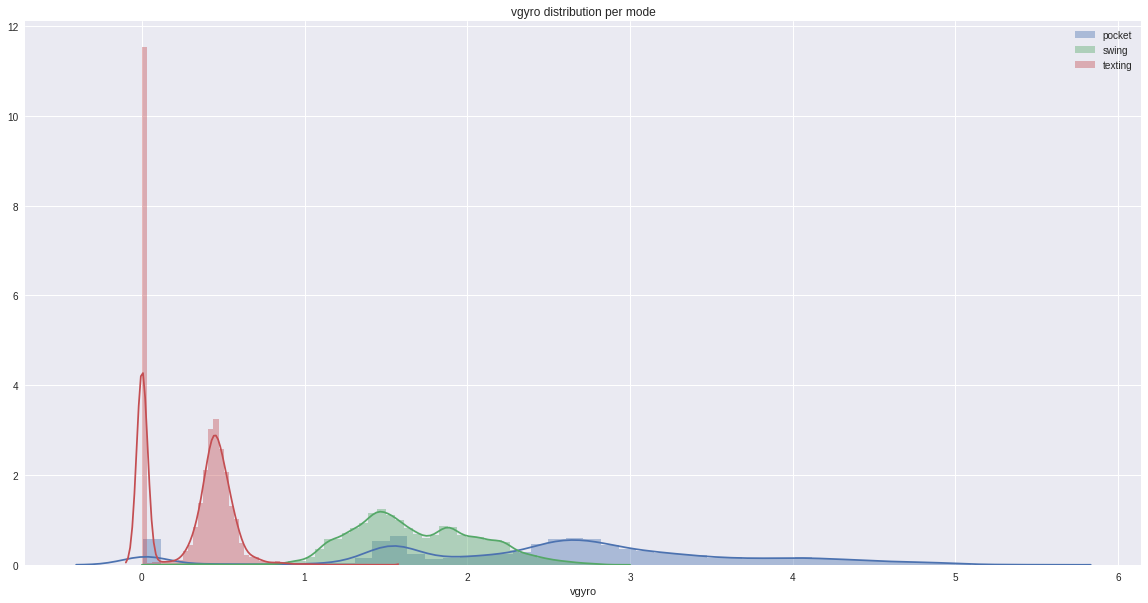

In [23]:
features = ['mgforce','mgyro','vgforce','vgyro']
for f in features:
    plt.figure(figsize=(20,10))
    plt.title(f + " distribution per mode")
    for l in LABELS:    
        if l != 'whatever':
            sns.distplot(rdf[rdf.label == l][f], label=l)
plt.legend()
plt.show()

## split train & test data

In [24]:
# take only relevants features :
df = rdf.iloc[:,13:]
df.head()

,wz,gforce,gyro,mgforce,mgyro,vgforce,vgyro
0,-0.4187,0.689125,0.647603,1.115267,1.656783,0.120552,1.656783
1,-0.4187,0.689125,0.647603,1.115267,1.656783,0.120552,1.656783
2,-0.4187,0.983347,0.647603,1.115267,1.656783,0.120552,1.656783
3,-0.0352,0.983347,0.464174,1.115267,1.656783,0.120552,1.656783
4,-0.0352,0.983347,0.464174,1.115267,1.656783,0.120552,1.656783


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df.devicemode, test_size=0.3, random_state=42)


AttributeError: 'DataFrame' object has no attribute 'devicemode'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_jobs=4,n_neighbors=4)
knn.fit(X_train,y_train)
knn4_pred = knn.predict(X_test)
print(confusion_matrix(y_pred=knn4_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn4_pred,y_true=y_test),cmap='Greens')

In [ ]:
from sklearn.metrics import classification_report
print('classification report results:\r\n' + classification_report(y_pred=knn4_pred,y_true=y_test))

In [ ]:
### calculates features for validation data :

In [40]:
rvl['gforce'] = np.sqrt(rvl['gfx']**2 + rvl['gFy']**2 + rvl['gFz']**2) 
rvl['gyro'] = np.sqrt(rvl['wx']**2 + rvl['wy']**2 + rvl['wz']**2) 

In [41]:
rvl['mgforce'] = rvl['gforce'].rolling(window=128,center=False).mean()
rvl['mgforce'].fillna(value=rvl['mgforce'].mean(),inplace=True)

rvl['mgyro'] = rvl['gyro'].rolling(window=128,center=False).mean()
rvl['mgyro'].fillna(value=rvl['mgyro'].mean(),inplace=True)


In [42]:
rvl['vgforce'] = rvl['gforce'].rolling(window=128,center=False).var()
rvl['vgforce'].fillna(value=rvl['vgforce'].mean(),inplace=True)
rvl['vgyro'] = rvl['gyro'].rolling(window=128,center=False).mean()
rvl['vgyro'].fillna(value=rvl['vgyro'].mean(),inplace=True)

0

In [43]:
vl = rvl[[devicemode,gforce,gyro,mgforce,mgyro,vgforce,vgyro]]

NameError: name 'devicemode' is not defined